In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import streamlit as st
from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient
from scipy.stats import norm
from datetime import datetime, timedelta
import random

from ab_testing.constants import client_name, target_col
from ab_testing.data_acquisition.acquire_data import queries_dict  # AcquireData
from ab_testing.distribution_fit.fit_distribution import FitDistribution
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

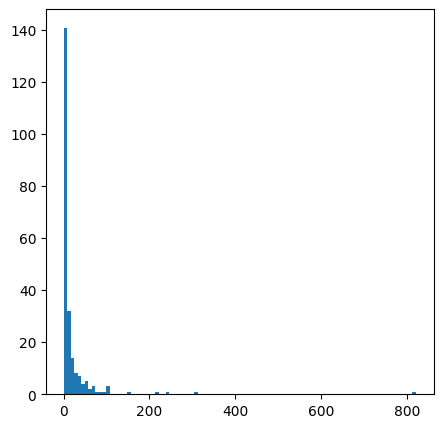

Mean of the logs of the samples: 1.8472476475718806
Mean of the samples: 20.99097131345052
Mean of the samples: 0.47649504881532684


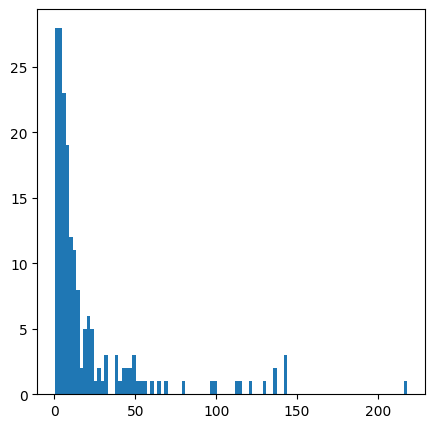

Mean of the logs of the samples: 2.196202189130646
Mean of the samples: 21.381223115934528
Mean of the samples: 0.3976907499563823


In [2]:
true_conv_rate_C = 0.02
true_mean_of_logs_of_spend_C = 2
true_variance_of_logs_of_spend_C = 2

true_conv_rate_P = 0.02
true_mean_of_logs_of_spend_P = 2+np.log(1.1)
true_variance_of_logs_of_spend_P = 2

number_of_data_samples = 10000



data_revenue_C = np.random.lognormal(
        true_mean_of_logs_of_spend_C,
        np.sqrt(true_variance_of_logs_of_spend_C),
        number_of_data_samples,
    )

data_all_C = np.random.binomial(1, true_conv_rate_C, number_of_data_samples).astype(
        float
    )
data_all_C[data_all_C > 0] = data_revenue_C[data_all_C > 0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(data_all_C[data_all_C > 0], density=False, bins=100)
plt.show()
print(f"Mean of the logs of the samples: {np.mean(np.log(data_all_C[data_all_C > 0]))}")
print(f"Mean of the samples: {np.mean(data_all_C[data_all_C > 0])}")
print(f"Mean of the samples: {np.mean(data_all_C)}")



data_revenue_P = np.random.lognormal(
        true_mean_of_logs_of_spend_P,
        np.sqrt(true_variance_of_logs_of_spend_P),
        number_of_data_samples,
    )

data_all_P = np.random.binomial(1, true_conv_rate_P, number_of_data_samples).astype(
        float
    )
data_all_P[data_all_P > 0] = data_revenue_P[data_all_P > 0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(data_all_P[data_all_P > 0], density=False, bins=100)
plt.show()
print(f"Mean of the logs of the samples: {np.mean(np.log(data_all_P[data_all_P > 0]))}")
print(f"Mean of the samples: {np.mean(data_all_P[data_all_P > 0])}")
print(f"Mean of the samples: {np.mean(data_all_P)}")


In [3]:
def create_P_and_C_datasets(
    true_conv_rate_C=0.02,
    true_mean_of_logs_of_spend_C=2,
    true_variance_of_logs_of_spend_C=2,
    true_conv_rate_P=0.02,
    true_mean_of_logs_of_spend_P=2 + np.log(1.1),
    true_variance_of_logs_of_spend_P=2,
    number_of_data_samples = 10000
):
    
    data_revenue_C = np.random.lognormal(
            true_mean_of_logs_of_spend_C,
            np.sqrt(true_variance_of_logs_of_spend_C),
            number_of_data_samples,
        )
    data_all_C = np.random.binomial(1, true_conv_rate_C, number_of_data_samples).astype(
            float
        )
    data_all_C[data_all_C > 0] = data_revenue_C[data_all_C > 0]

    data_revenue_P = np.random.lognormal(
        true_mean_of_logs_of_spend_P,
        np.sqrt(true_variance_of_logs_of_spend_P),
        number_of_data_samples,
    )
    data_all_P = np.random.binomial(1, true_conv_rate_P, number_of_data_samples).astype(
        float
    )
    data_all_P[data_all_P > 0] = data_revenue_P[data_all_P > 0]

    return data_all_C, data_all_P

In [27]:
def perform_n_days_of_testing(n = 30):
    list_probabs_revenue_test = []
    list_losses_revenue_test_P = []
    list_losses_revenue_test_C = []
    list_total_gains_revenue_test_P = []
    list_total_gains_revenue_test_C = []
    list_average_spends_P = []
    list_average_spends_C = []

    a_prior_beta_revenue_test_P = 2
    b_prior_beta_revenue_test_P = 98
    m_prior_revenue_test_P = 2
    a_prior_ig_revenue_test_P = 0
    b_prior_ig_revenue_test_P = 0
    w_prior_revenue_test_P = 10

    a_prior_beta_revenue_test_C = 2
    b_prior_beta_revenue_test_C = 98
    m_prior_revenue_test_C = 2
    a_prior_ig_revenue_test_C = 0
    b_prior_ig_revenue_test_C = 0
    w_prior_revenue_test_C = 10

    num_datapoints_P = 0
    num_datapoints_C = 0
    num_conversions_P = 0
    num_conversions_C = 0
    sum_spends_P = 0
    sum_spends_C = 0


    for i in range(n):
        data_all_C, data_all_P = create_P_and_C_datasets()
        
        test_revenue = DeltaLognormalDataTest()
        test_revenue.add_variant_data(name = "P", data = data_all_P, a_prior_beta = a_prior_beta_revenue_test_P, b_prior_beta = b_prior_beta_revenue_test_P, 
                                            m_prior = m_prior_revenue_test_P, a_prior_ig = a_prior_ig_revenue_test_P, b_prior_ig = b_prior_ig_revenue_test_P, w_prior = w_prior_revenue_test_P)
        test_revenue.add_variant_data(name = "C", data = data_all_C, a_prior_beta = a_prior_beta_revenue_test_C, b_prior_beta = b_prior_beta_revenue_test_C, 
                                            m_prior = m_prior_revenue_test_C, a_prior_ig = a_prior_ig_revenue_test_C, b_prior_ig = b_prior_ig_revenue_test_C, w_prior = w_prior_revenue_test_C)
        res_revenue_test = test_revenue.evaluate(seed=42)

        a_prior_beta_revenue_test_P = res_revenue_test[0]['a_post_beta']
        b_prior_beta_revenue_test_P = res_revenue_test[0]['b_post_beta']
        m_prior_revenue_test_P = res_revenue_test[0]['m_post']
        a_prior_ig_revenue_test_P = res_revenue_test[0]['a_post_ig']
        b_prior_ig_revenue_test_P = res_revenue_test[0]['b_post_ig']
        w_prior_revenue_test_P = res_revenue_test[0]['w_post']

        a_prior_beta_revenue_test_C = res_revenue_test[1]['a_post_beta']
        b_prior_beta_revenue_test_C = res_revenue_test[1]['b_post_beta']
        m_prior_revenue_test_C = res_revenue_test[1]['m_post']
        a_prior_ig_revenue_test_C = res_revenue_test[1]['a_post_ig']
        b_prior_ig_revenue_test_C = res_revenue_test[1]['b_post_ig']
        w_prior_revenue_test_C = res_revenue_test[1]['w_post']

        
        list_probabs_revenue_test.append(res_revenue_test[0]['prob_being_best'])
        list_losses_revenue_test_P.append(res_revenue_test[0]['expected_loss'])
        list_losses_revenue_test_C.append(res_revenue_test[1]['expected_loss'])
        list_total_gains_revenue_test_P.append(res_revenue_test[0]['expected_total_gain'])
        list_total_gains_revenue_test_C.append(res_revenue_test[1]['expected_total_gain'])

        num_datapoints_P += len(data_all_P)
        num_datapoints_C += len(data_all_C)

        sum_spends_P +=  data_all_P.sum()
        sum_spends_C +=  data_all_C.sum()

        list_average_spends_P.append(sum_spends_P/num_datapoints_P)
        list_average_spends_C.append(sum_spends_C/num_datapoints_C)
    
    return list_probabs_revenue_test, list_losses_revenue_test_P, list_losses_revenue_test_C, list_total_gains_revenue_test_P, list_total_gains_revenue_test_C, list_average_spends_P, list_average_spends_C



In [28]:
A,B,C,D,E,F,G = perform_n_days_of_testing()

<AxesSubplot: title={'center': 'REVENUE TEST: Estimated mean revenue over the period of running the test'}, ylabel='Average revenue'>

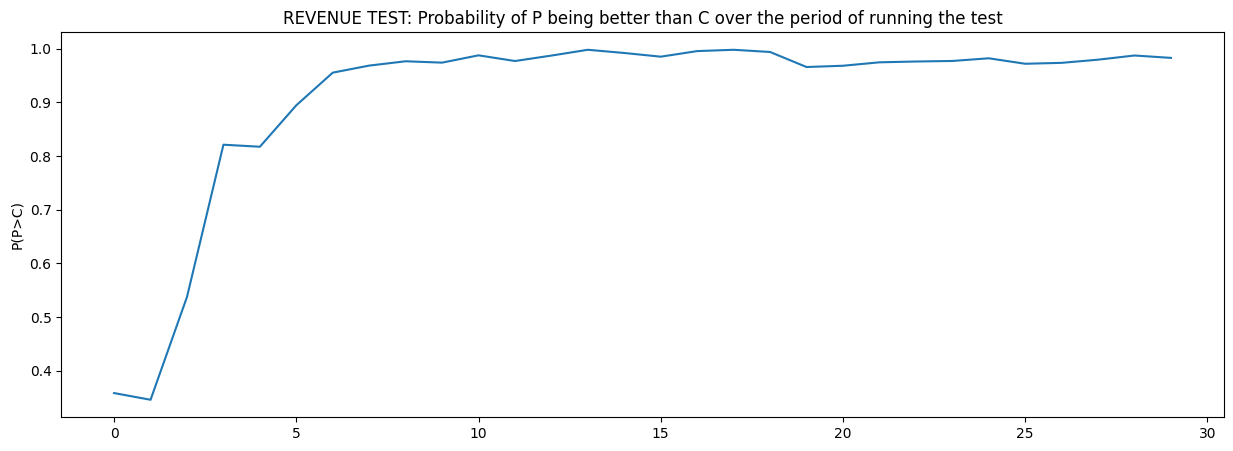

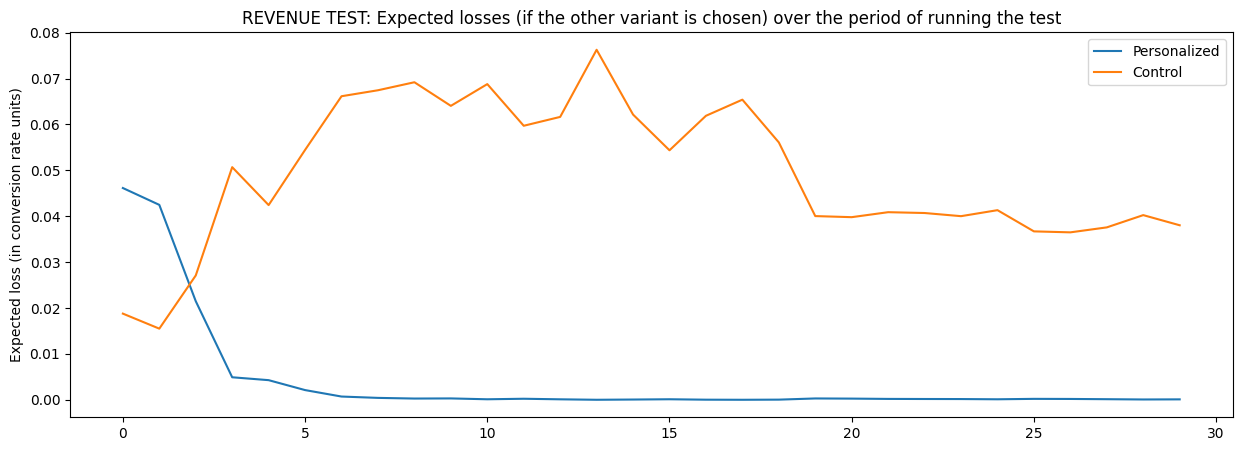

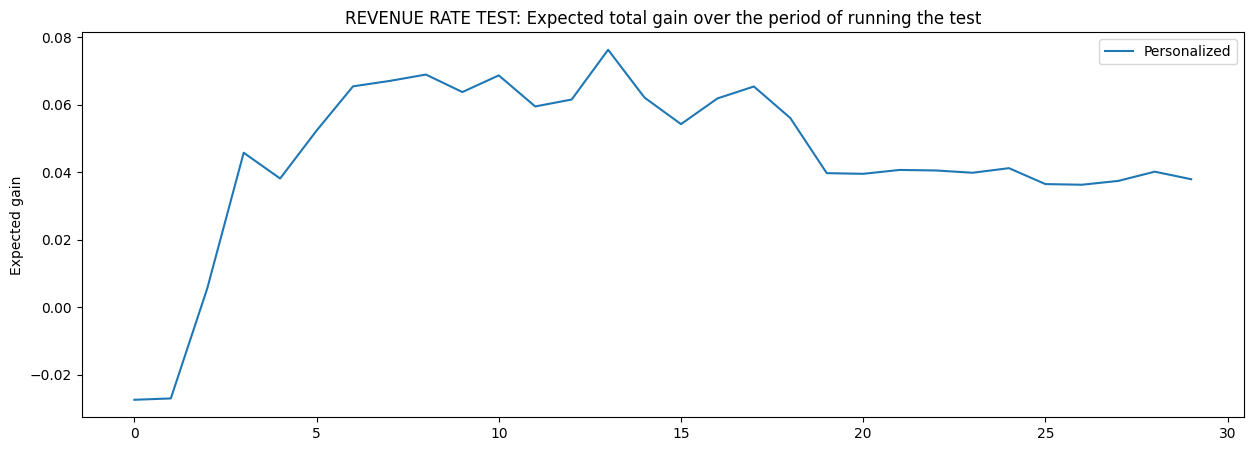

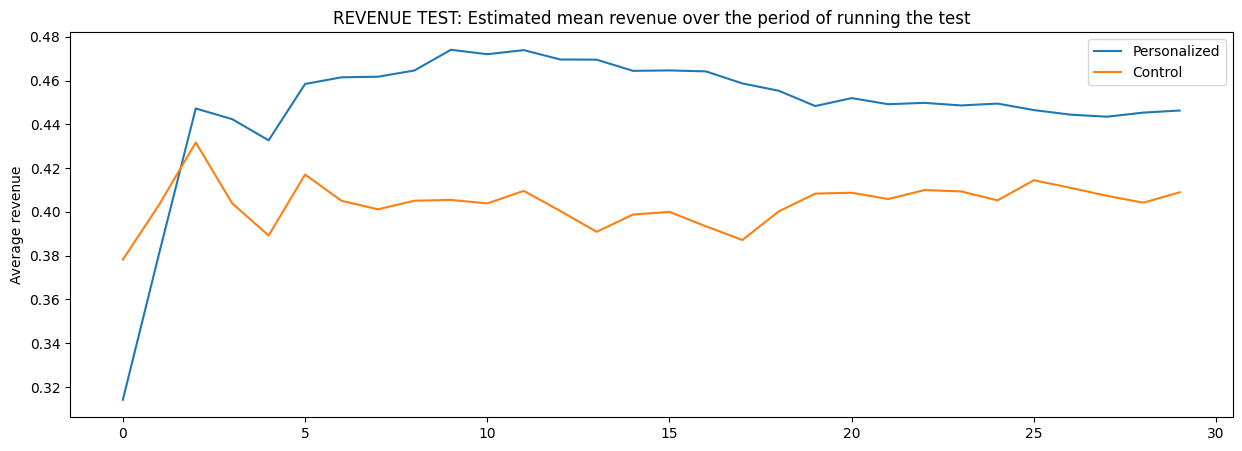

In [30]:
fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('REVENUE TEST: Probability of P being better than C over the period of running the test')
ax.set_ylabel('P(P>C)')
sns.lineplot(x = list(range(30)), y = A)


fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('REVENUE TEST: Expected losses (if the other variant is chosen) over the period of running the test')
ax.set_ylabel('Expected loss (in conversion rate units)')
sns.lineplot(x = list(range(30)), y = B, label = 'Personalized')
sns.lineplot(x = list(range(30)), y = C, label = 'Control')

fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('REVENUE RATE TEST: Expected total gain over the period of running the test')
ax.set_ylabel('Expected gain')
sns.lineplot(x = list(range(30)), y = D, label = 'Personalized')

fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('REVENUE TEST: Estimated mean revenue over the period of running the test')
ax.set_ylabel('Average revenue')
sns.lineplot(x = list(range(30)), y = F, label = 'Personalized')
sns.lineplot(x = list(range(30)), y = G, label = 'Control')

In [15]:
C

[0.0890307,
 0.0662736,
 0.0429587,
 0.0425023,
 0.0684066,
 0.0715794,
 0.0604834,
 0.0722128,
 0.0700943,
 0.0724623,
 0.0733225,
 0.0669161,
 0.0558889,
 0.0390369,
 0.0404235,
 0.0399234,
 0.0378079,
 0.0372644,
 0.0294183,
 0.0276549,
 0.0251893,
 0.0259794,
 0.0281521,
 0.03396,
 0.0304342,
 0.0325173,
 0.0341053,
 0.0347871,
 0.0358147,
 0.0285614]

In [6]:
list_probabs_revenue_test = []
list_losses_revenue_test_P = []
list_losses_revenue_test_C = []
list_total_gains_revenue_test_P = []
list_total_gains_revenue_test_C = []
list_average_spends_P = []
list_average_spends_C = []

a_prior_beta_revenue_test_P = 0.5
b_prior_beta_revenue_test_P = 0.5
m_prior_revenue_test_P = 1
a_prior_ig_revenue_test_P = 0
b_prior_ig_revenue_test_P = 0
w_prior_revenue_test_P = 0.01

a_prior_beta_revenue_test_C = 0.5
b_prior_beta_revenue_test_C = 0.5
m_prior_revenue_test_C = 1
a_prior_ig_revenue_test_C = 0
b_prior_ig_revenue_test_C = 0
w_prior_revenue_test_C = 0.01

num_datapoints_P = 0
num_datapoints_C = 0
num_conversions_P = 0
num_conversions_C = 0
sum_spends_P = 0
sum_spends_C = 0


for i in range(30):
    data_all_C, data_all_P = create_P_and_C_datasets()
        
    test_revenue = DeltaLognormalDataTest()
    test_revenue.add_variant_data(name = "P", data = data_all_P, a_prior_beta = a_prior_beta_revenue_test_P, b_prior_beta = b_prior_beta_revenue_test_P, 
                                            m_prior = m_prior_revenue_test_P, a_prior_ig = a_prior_ig_revenue_test_P, b_prior_ig = b_prior_ig_revenue_test_P, w_prior = w_prior_revenue_test_P)
    test_revenue.add_variant_data(name = "C", data = data_all_C, a_prior_beta = a_prior_beta_revenue_test_C, b_prior_beta = b_prior_beta_revenue_test_C, 
                                            m_prior = m_prior_revenue_test_C, a_prior_ig = a_prior_ig_revenue_test_C, b_prior_ig = b_prior_ig_revenue_test_C, w_prior = w_prior_revenue_test_C)
    res_revenue_test = test_revenue.evaluate(seed=42)

    a_prior_beta_revenue_test_P = res_revenue_test[0]['a_post_beta']
    b_prior_beta_revenue_test_P = res_revenue_test[0]['b_post_beta']
    m_prior_revenue_test_P = res_revenue_test[0]['m_post']
    a_prior_ig_revenue_test_P = res_revenue_test[0]['a_post_ig']
    b_prior_ig_revenue_test_P = res_revenue_test[0]['b_post_ig']
    w_prior_revenue_test_P = res_revenue_test[0]['w_post']

    a_prior_beta_revenue_test_C = res_revenue_test[1]['a_post_beta']
    b_prior_beta_revenue_test_C = res_revenue_test[1]['b_post_beta']
    m_prior_revenue_test_C = res_revenue_test[1]['m_post']
    a_prior_ig_revenue_test_C = res_revenue_test[1]['a_post_ig']
    b_prior_ig_revenue_test_C = res_revenue_test[1]['b_post_ig']
    w_prior_revenue_test_C = res_revenue_test[1]['w_post']


    list_probabs_revenue_test.append(res_revenue_test[0]['prob_being_best'])
    list_losses_revenue_test_P.append(res_revenue_test[0]['expected_loss'])
    list_losses_revenue_test_C.append(res_revenue_test[1]['expected_loss'])
    list_total_gains_revenue_test_P.append(res_revenue_test[0]['expected_total_gain'])
    list_total_gains_revenue_test_C.append(res_revenue_test[1]['expected_total_gain'])

    sum_spends_P +=  data_all_P.sum()
    sum_spends_C +=  data_all_C.sum()

    list_average_spends_P.append(sum_spends_P/num_datapoints_P)
    list_average_spends_C.append(sum_spends_C/num_datapoints_C)

C:\Users\karol\AppData\Local\Temp\ipykernel_25788\2700141137.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  list_average_spends_P.append(sum_spends_P/num_datapoints_P)
C:\Users\karol\AppData\Local\Temp\ipykernel_25788\2700141137.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  list_average_spends_C.append(sum_spends_C/num_datapoints_C)


In [7]:
res_revenue_test

[{'variant': 'P',
  'totals': 10000,
  'positives': 208,
  'sum_values': 5251.80808,
  'avg_values': 0.52518,
  'avg_positive_values': 25.24908,
  'prob_being_best': 0.91385,
  'expected_loss': 0.0006925,
  'expected_total_gain': 0.0244426,
  'a_post_beta': 5918.5,
  'b_post_beta': 294082.5,
  'a_post_ig': 2959.0,
  'b_post_ig': 6011.632150504515,
  'w_post': 5918.01,
  'm_post': 2.0950318796424643},
 {'variant': 'C',
  'totals': 10000,
  'positives': 213,
  'sum_values': 4406.53019,
  'avg_values': 0.44065,
  'avg_positive_values': 20.68794,
  'prob_being_best': 0.08615,
  'expected_loss': 0.0251351,
  'expected_total_gain': -0.0244426,
  'a_post_beta': 6014.5,
  'b_post_beta': 293986.5,
  'a_post_ig': 3007.0,
  'b_post_ig': 6097.1334240202,
  'w_post': 6014.01,
  'm_post': 2.023698182799815}]

In [15]:
test_revenue = DeltaLognormalDataTest()
test_revenue.add_variant_data(name = "P", data = data_all_C)
test_revenue.add_variant_data(name = "C", data = data_all_P)

In [16]:
res_revenue_test = test_revenue.evaluate(seed=42)

In [17]:
res_revenue_test

[{'variant': 'P',
  'totals': 10000,
  'positives': 208,
  'sum_values': 3538.16002,
  'avg_values': 0.35382,
  'avg_positive_values': 17.01038,
  'prob_being_best': 0.62435,
  'expected_loss': 0.0193353,
  'expected_total_gain': 0.0248217,
  'a_posteriors_beta': 208.5,
  'b_posteriors_beta': 9792.5,
  'a_posteriors_ig': 104.0,
  'b_posteriors_ig': 210.2483571058326,
  'w_posteriors': 208.01,
  'm_posteriors': 1.84066228867409},
 {'variant': 'C',
  'totals': 10000,
  'positives': 188,
  'sum_values': 3811.18157,
  'avg_values': 0.38112,
  'avg_positive_values': 20.27224,
  'prob_being_best': 0.37565,
  'expected_loss': 0.0441569,
  'expected_total_gain': -0.0248217,
  'a_posteriors_beta': 188.5,
  'b_posteriors_beta': 9812.5,
  'a_posteriors_ig': 94.0,
  'b_posteriors_ig': 151.23928511295273,
  'w_posteriors': 188.01,
  'm_posteriors': 2.0804298207985297}]

In [13]:
test_revenue.data

{'P': {'totals': 1000000,
  'positives': 50181,
  'sum_values': 986748.2163697061,
  'sum_logs': 99820.41239504024,
  'sum_logs_2': 298704.95568289235,
  'a_prior_beta': 0.5,
  'b_prior_beta': 0.5,
  'm_prior': 1,
  'a_prior_ig': 0,
  'b_prior_ig': 0,
  'w_prior': 0.01},
 'C': {'totals': 1000000,
  'positives': 49723,
  'sum_values': 1091157.4827426586,
  'sum_logs': 104363.42365572964,
  'sum_logs_2': 318256.42139960104,
  'a_prior_beta': 0.5,
  'b_prior_beta': 0.5,
  'm_prior': 1,
  'a_prior_ig': 0,
  'b_prior_ig': 0,
  'w_prior': 0.01}}